# Notebook to look at options for using Kinefly-like methods to extract wing kinematics

Until now, I've been trying stuff more like what I did in the Cohen Lab (binarization, segmentation, etc),
but am now curious about using the user ROIs + edge detection or something

## Import

In [1]:
import os
import glob
import cv2

import numpy as np
import matplotlib.pyplot as plt
import cv2

import skimage.morphology  as morphology

from scipy.signal import find_peaks

from skimage.color import label2rgb, rgb2gray
from skimage.exposure import equalize_hist, equalize_adapthist, rescale_intensity
from skimage.feature import canny, peak_local_max
from skimage.filters import threshold_otsu, gaussian, threshold_multiotsu, sobel
from skimage.filters.rank import gradient
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border, flood, flood_fill, watershed
from skimage.transform import hough_line, hough_line_peaks
from skimage.util import invert, img_as_float, img_as_ubyte, img_as_uint

from mosquito.fly_tracking_frame import FlyFrame, get_angle_from_points
from mosquito.get_wing_kinematics import load_video_data, get_highspeed_frame_fg, get_wing_imgs, ArrayVideoCapture


## Params

In [2]:
plt.style.use('dark_background')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels

## Helper functions

In [27]:
def get_wing_edges(im, mask, hinge_pt, canny_sigma=3.0):
    """
    Function to extract edges from an image of the wings
    """
    # convert from RGB as needed
    if len(im.shape) > 2:
        im = rgb2gray(im)

    # get edge image (masked)
    edges = canny(im, sigma=canny_sigma)
    edges *= mask

    # find edges as connected components
    props = regionprops(label(edges))

    # get angles of each connected component relative to hinge point
    edge_angles = list()
    for p in props:
        # centroid of current component
        cm = p.centroid

        # note that we need to switch order of centroid coordinates
        edge_angles.append(get_angle_from_points(hinge_pt, np.array([cm[1], cm[0]])))

    # pull out max and min angles
    if len(edge_angles) == 0:
        max_angle = None
        min_angle = None
        
        print('No edges detected')
        
    elif len(edge_angles) == 1:
        max_angle = edge_angles[0]
        min_angle = None

    else:
        max_angle = max(edge_angles)
        min_angle = min(edge_angles)
        
    return max_angle, min_angle
    

In [4]:
# -----------------------------------------------------------------------------
# callback function to return x,y coordinates of a mouse DOUBLE LEFT CLICK 
def get_xy(event, x, y, flags, param):
    global mouseX, mouseY
    if event == cv2.EVENT_LBUTTONDBLCLK:
        print((x, y))
        mouseX, mouseY = x, y
        
# -----------------------------------------------------------------------------
# get capillary tip manually        
def get_cap_tip(img):
    clone = img.copy()
    win_name = 'get capillary tip (double click, enter when finished)'
    cv2.namedWindow(win_name, cv2.WINDOW_NORMAL)
    cv2.setMouseCallback(win_name, get_xy)
    cv2.imshow(win_name, img)

    while True:
        cv2.imshow(win_name, img)
        try:
            img = clone.copy()
            cv2.circle(img, (mouseX, mouseY), 4, (255, 0, 0), -1)
        except NameError:
            pass

        k = cv2.waitKey(1) & 0xFF
        if k == 13:
            break

    img = clone.copy()
    cv2.destroyAllWindows()

    return (mouseX, mouseY)



## Load data

In [5]:
# info for file to load
data_folder = 48  # 46
axo_num = 0
frame_range = (0, 1000)
return_cap_flag = False
wing_side = 'right'
vid_type = 'lowspeed'  # 'lowspeed' or 'highspeed'

imgs, _ = load_video_data(data_folder, axo_num, frame_range=frame_range, return_cap_flag=return_cap_flag)


In [6]:
# make instance of fly frame class
fly_frame = FlyFrame()


In [ ]:
# get edge detection values
if vid_type == 'highspeed':
    canny_sigma = 3.5

elif vid_type == 'lowspeed':
    canny_sigma = 1.5
    

## Get fly reference frame

In [7]:
# draw on reference frame
cap = ArrayVideoCapture(imgs.copy())
fly_frame.run_video(cap)
cap.release()


In [8]:
# get params for drawn on ref frame
params = fly_frame.params

# get masks
mask = getattr(fly_frame, f'{wing_side}_wing').mask
mask = (mask > 0)

# get hinge point
hinge_pt = fly_frame.params[f'{wing_side}_wing']['hinge_pt']

# get radii of ROI
radius_inner = params[f'{wing_side}_wing']['radius_inner']
radius_outer = params[f'{wing_side}_wing']['radius_outer']
radius_avg = (radius_inner + radius_outer)/2.0


## Detect edges and assign them to trailing/leading edges

In [26]:
# detect wing edges
cap = ArrayVideoCapture(imgs.copy())

window_name = 'edge detection'

angle_max_all = list()
angle_min_all = list()
angle_max_pt_all = list()
angle_min_pt_all = list()

cc = 0
while True:
    # read next frame
    ret, frame = cap.read()
    if not ret:
        break

    # get edges
    angle_max, angle_min = get_wing_edges(frame, mask, hinge_pt, canny_sigma=canny_sigma)

    # get coordinate points for edges (for display) and store values
    if angle_max is not None:
        # calculate point
        angle_max_pt = hinge_pt + (radius_avg * np.array([np.cos(angle_max), np.sin(angle_max)])) 

        # draw circle
        cv2.circle(frame, angle_max_pt.astype('int'), 4, (255, 0, 0, 255), -1)
        
        # store
        angle_max_all.append(angle_max)
        angle_max_pt_all.append(angle_max_pt)
    else:
        print(cc)
        
    if angle_min is not None:
        # calculate point
        angle_min_pt = hinge_pt + (radius_avg * np.array([np.cos(angle_min), np.sin(angle_min)]))  

        # draw edges on image
        cv2.circle(frame, angle_min_pt.astype('int'), 4, (0, 0, 255, 255), -1)
    
        # store values
        angle_min_all.append(angle_min)          
        angle_min_pt_all.append(angle_min_pt)
    
    # show image
    cv2.imshow(window_name, frame)
    
    # playback options
    k = cv2.waitKey(25) & 0xFF
    if k == 27:
        break

    cc += 1

cv2.destroyAllWindows()
cap.release()

No edges detected
14
No edges detected
16
No edges detected
18
No edges detected
20
No edges detected
22
No edges detected
24
No edges detected
26
No edges detected
47
No edges detected
49
No edges detected
51
No edges detected
53
No edges detected
57
No edges detected
77
No edges detected
81
No edges detected
83
No edges detected
85
No edges detected
87
No edges detected
89


## Test edge detection across frames

In [233]:
cap = ArrayVideoCapture(imgs.copy())
window_name = 'edge detection'
cv2.namedWindow(window_name)

radius_inner = params['right_wing']['radius_inner']
radius_outer = params['right_wing']['radius_outer']
radius_avg = (radius_inner + radius_outer)/2.0

angle_max_all = list()
angle_min_all = list()
angle_max_pt_all = list()
angle_min_pt_all = list()

while True:
    # read next frame
    ret, frame = cap.read()
    if not ret:
        break

    # get edges
    angle_max, angle_min = get_wing_edges(frame, right_mask, right_hinge)

    # get coordinate points for edges (for display)
    angle_max_pt = right_hinge + (radius_avg * np.array([np.cos(angle_max), np.sin(angle_max)])) 
    angle_min_pt = right_hinge + (radius_avg * np.array([np.cos(angle_min), np.sin(angle_min)]))  

    # store values for angles 
    angle_max_all.append(angle_max)
    angle_min_all.append(angle_min)
    angle_max_pt_all.append(angle_max_pt)
    angle_min_pt_all.append(angle_min_pt)
    
    # draw edges on image
    cv2.circle(frame, angle_max_pt.astype('int'), 4, (255, 0, 0, 255), -1)
    cv2.circle(frame, angle_min_pt.astype('int'), 4, (0, 0, 255, 255), -1)
    
    # show image
    cv2.imshow(window_name, frame)
    
    # playback options
    k = cv2.waitKey(25) & 0xFF
    if k == 27:
        break


cv2.destroyAllWindows()
cap.release()


(0.0, 40.0)

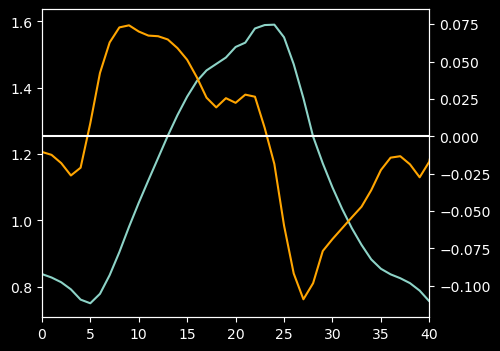

In [172]:
# get estimate of wing center of mass (at least in polar angle coordinates) to distinguish between leading and trailing edges
wing_cm_angles = (np.asarray(angle_max_all) + np.asarray(angle_min_all))/2.0

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(wing_cm_angles)

ax1 = ax.twinx()
ax1.plot(np.gradient(wing_cm_angles), color='orange')
ax1.axhline(0, color='w')
ax.set_xlim([0, 40])

(0.0, 40.0)

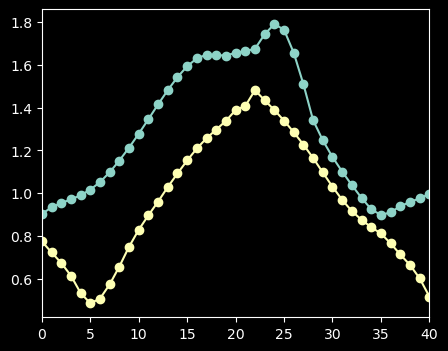

In [169]:
# what happens if we just look at measured angles
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(angle_max_all, 'o-')
ax.plot(angle_min_all, 'o-')

ax.set_xlim([0, 40])

In [178]:
# for first pass, just use simple velocity sign to make assignment
cap = ArrayVideoCapture(imgs.copy())
window_name = 'edge detection'
cv2.namedWindow(window_name)

wing_cm_vel = np.gradient(wing_cm_angles)
cc = 0

while True:
    # read next frame
    ret, frame = cap.read()
    if not ret:
        break

    # get edge angles
    angle_max = angle_max_all[cc]
    angle_min = angle_min_all[cc]

    # get coordinate points for edges (for display)
    angle_max_pt = right_hinge + (radius_avg * np.array([np.cos(angle_max), np.sin(angle_max)])) 
    angle_min_pt = right_hinge + (radius_avg * np.array([np.cos(angle_min), np.sin(angle_min)]))  

    # leading_edge = angle_max_pt
    # trailing_edge = angle_min_pt
  
    if wing_cm_vel[cc] >= 0:
        leading_edge = angle_max_pt
        trailing_edge = angle_min_pt
    else:
        leading_edge = angle_min_pt
        trailing_edge = angle_max_pt
        
    # draw edges on image
    cv2.circle(frame, leading_edge.astype('int'), 4, (255, 0, 0, 255), -1)
    cv2.circle(frame, trailing_edge.astype('int'), 4, (0, 0, 255, 255), -1)
    
    # show image
    cv2.imshow(window_name, frame)
    
    # playback options
    k = cv2.waitKey(0) & 0xFF
    if k == 27:
        break
    
    cc += 1
    
cv2.destroyAllWindows()
cap.release()


(355, 430)
(359, 429)
(359, 429)
(356, 432)


In [188]:
# # Use manual clicking to assign leading vs trailing edge
# cap = ArrayVideoCapture(imgs.copy())
# window_name = 'edge detection'
# cv2.namedWindow(window_name)

# leading_edge_all = list()
# trailing_edge_all = list()

# cc = 0

# while True:
#     # read next frame
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # get edge angles
#     angle_max = angle_max_all[cc]
#     angle_min = angle_min_all[cc]

#     # get coordinate points for edges (for display)
#     angle_max_pt = right_hinge + (radius_avg * np.array([np.cos(angle_max), np.sin(angle_max)])) 
#     angle_min_pt = right_hinge + (radius_avg * np.array([np.cos(angle_min), np.sin(angle_min)]))  
        
#     # draw edges on image
#     cv2.circle(frame, angle_max_pt.astype('int'), 4, (255, 0, 0, 255), -1)
#     cv2.circle(frame, angle_min_pt.astype('int'), 4, (0, 0, 255, 255), -1)
    
#     # show image
#     cv2.imshow(window_name, frame)
#     cv2.setMouseCallback(window_name, get_xy)
    
#     # playback options
#     k = cv2.waitKey(0) & 0xFF
#     if k == 27:
#         break

#     # we're clicking on leading edge, so find closest point and store
#     pts = np.vstack([angle_max_pt, angle_min_pt])
#     dist = np.linalg.norm(pts - np.array([mouseX, mouseY]), axis=1)
#     sort_ind = np.argsort(dist) 
#     leading_edge_all.append(pts[sort_ind[0]])
#     trailing_edge_all.append(pts[sort_ind[1]])
    
#     # increment counter
#     cc += 1
    
# cv2.destroyAllWindows()
# cap.release()


(0.0, 40.0)

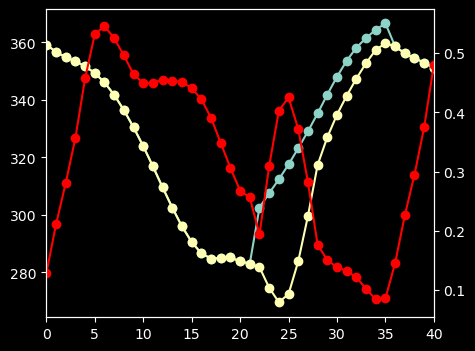

In [228]:
# what happens if we just look at measured angles
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(np.asarray(leading_edge_all)[:,0], 'o-')
ax.plot(np.asarray(angle_max_pts_all)[:,0], 'o-')
# ax.plot(np.asarray(wing_cm_angles), 'o-')

ax1 = ax.twinx()
ax1.plot(np.asarray(angle_max_all) - np.asarray(angle_min_all), 'o-', color='red')

ax.set_xlim([0, 40])



(0.0, 40.0)

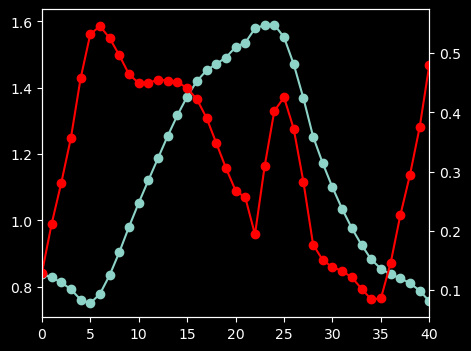

In [231]:
# what happens if we just look at measured angles
fig, ax = plt.subplots(figsize=(5,4))

ax.plot(wing_cm_angles, 'o-')

ax1 = ax.twinx()
ax1.plot(np.asarray(angle_max_all) - np.asarray(angle_min_all), 'o-', color='red')

ax.set_xlim([0, 40])

It seems like switches between min/max angles for leading/trailing correspond (roughly) to minima in the difference between max and min wing angles over time

(0.0, 120.0)

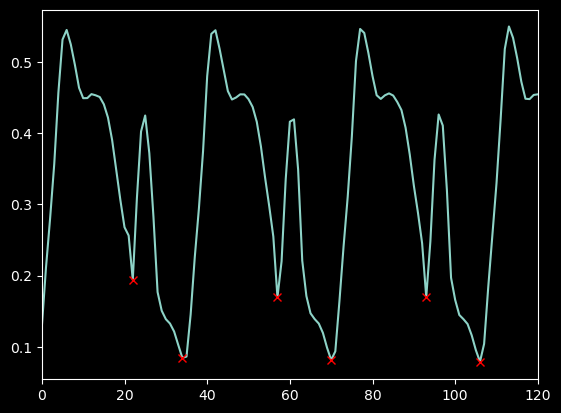

In [241]:
# find such minima
wing_angle_diff = np.asarray(angle_max_all) - np.asarray(angle_min_all)
t_samp = np.arange(wing_angle_diff.size)

pks, props = find_peaks(-1*wing_angle_diff, prominence=(0.1, None))

fig, ax = plt.subplots()

ax.plot(t_samp, wing_angle_diff)
ax.plot(t_samp[pks], wing_angle_diff[pks], 'rx')

ax.set_xlim([0, 120])


In [254]:
# get average velocity between these points
chunk_idx = [np.sum(t >= pks) for t in t_samp]
chunk_idx = np.asarray(chunk_idx)

leading_edge_all = []
trailing_edge_all = []

angle_max_arr = np.asarray(angle_max_all)
angle_min_arr = np.asarray(angle_min_all)

for chunk in np.unique(chunk_idx):
    idx = (chunk_idx == chunk)
    vel_mean = np.mean(wing_cm_vel[idx])

    if vel_mean < 0:
        leading_edge = angle_min_arr[idx]
        trailing_edge = angle_max_arr[idx]
    else:
        leading_edge = angle_max_arr[idx]
        trailing_edge = angle_min_arr[idx]
        
    leading_edge_all.extend(leading_edge)
    trailing_edge_all.extend(trailing_edge)
    


In [255]:
# try with heuristic applied
cap = ArrayVideoCapture(imgs.copy())
window_name = 'edge detection'
cv2.namedWindow(window_name)

wing_cm_vel = np.gradient(wing_cm_angles)
cc = 0

while True:
    # read next frame
    ret, frame = cap.read()
    if not ret:
        break

    # get edge angles
    leading_edge_ang = leading_edge_all[cc]
    trailing_edge_ang = trailing_edge_all[cc]

    # get coordinate points for edges (for display)
    leading_edge = right_hinge + (radius_avg * np.array([np.cos(leading_edge_ang), np.sin(leading_edge_ang)])) 
    trailing_edge = right_hinge + (radius_avg * np.array([np.cos(trailing_edge_ang), np.sin(trailing_edge_ang )]))  

    # draw edges on image
    cv2.circle(frame, leading_edge.astype('int'), 4, (255, 0, 0, 255), -1)
    cv2.circle(frame, trailing_edge.astype('int'), 4, (0, 0, 255, 255), -1)
    
    # show image
    cv2.imshow(window_name, frame)
    
    # playback options
    k = cv2.waitKey(0) & 0xFF
    if k == 27:
        break
    
    cc += 1
    
cv2.destroyAllWindows()
cap.release()


## Version with OpenCV

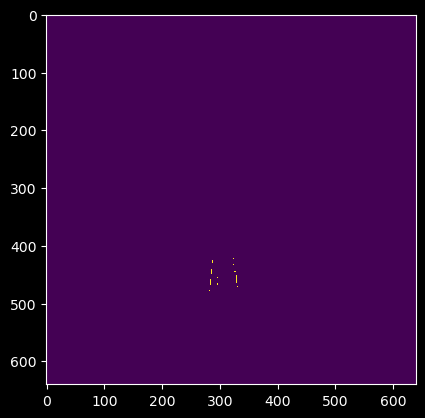

In [126]:
# Let's try the same in opencv
blur = cv2.GaussianBlur(im_gray, (9, 9), 0)
# blur = cv2.bilateralFilter(im_gray, 5, 
edges = cv2.Canny(blur, 100, 100)
edges *= right_mask

plt.imshow(edges, interpolation='none')

In [127]:
# get connected components
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(edges)

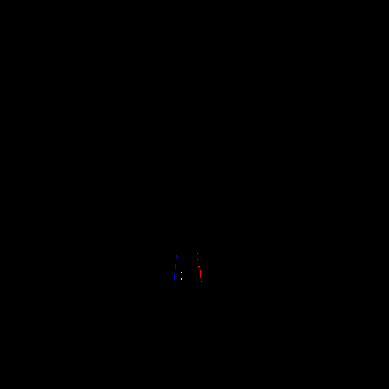

In [128]:
fig, ax = plt.subplots()
ax.imshow(label2rgb(labels), interpolation='none')
ax.set_axis_off()

In [129]:
num_labels

4

In [39]:
# # trying hough transform to extract edges -- doesn't work!
# # Step 1: Edge Detection
# edges = canny(im_gray, sigma=1.0)
# edges *= right_mask

# # Step 2: Hough Transform
# hough_space, angles, distances = hough_line(edges)

# # Step 2.5: display image
# fig, ax = plt.subplots()
# ax.imshow(edges)
# ax.set_axis_off()

# # # Step 3: Extracting Lines
# for _, angle, dist in zip(*hough_line_peaks(hough_space, angles, distances)):
#     (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
#     ax.axline((x0, y0), slope=np.tan(angle + np.pi / 2), color='red')

